In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.special import logsumexp
import multiprocessing
import time

In [2]:
print("Starting time:", time.ctime())

Starting time: Sat Sep 11 06:41:58 2021


# Evaluating the Parisi formula for a pure p-spin glass

The goal here is to calculate the zero-temperature Parisi constant, and compare it to the maximum satisfying fraction of randomXORSAT instances.

## Using the Parisi formula

Wei-Kuo Chen says:
> I am not aware of numerical simulations for the Parisi constant P(K) for large K. Nevertheless, this constant can be written as the Parisi formula, which is a convex optimization problem (see Theorem 1 in https://arxiv.org/pdf/1606.05335.pdf). With this, it should be fairly easy to run a numerical simulation to approximate P(K) for large K.


Paraphrased from the linked paper:
> We introduce the space $U$ that collects all nonnegative and nondecreasing functions $f$ on $[0,1)$ that are right continuous and satisfy $\int_0^1 f(t)dt < \infty$. Let's say $f$ has $k$ jumps. Then it has value $m_i$ in region $[q_i,q_{i+1})$, given $q_0 = 0$ and $q_{k+1} = 1$, where $m_i$ and $q_i$ are increasing and nonnegative. The distance metric $d$ is the integral of $f$, or equivalently, $d = \sum_{i=0}^k m_i(q_{i+1} - q_i)$.

$P(f) = \Psi_f(0, h) - 0.5 \int_0^1 t \xi^{''}(t)f(t) dt$

$\xi(s) =\sum_{p\ge 2} c_p^2 s^p$ Where the $c_p$'s are the mixing constants (mixed vs pure spin glasses).

$\partial_t \Psi_f(t,x) = -0.5\xi^{''}(t) 
\Big(
\partial_x^2 \Psi_f(t,x) + f(t) (\partial_x \Psi_f(t,x))^2
\Big)$

With boundary condition: $\Psi_f(1,x) = |x|$.

This can be solved recursively, by using the transformation $f(t) \Psi = \log \Phi$ for a piecewise, continuous function $f$.

This is the coefficient $a_{\ell} = \sqrt{ \xi^{'}(q_{\ell+1}) - \xi^{'}(q_{l}) }$

In [3]:
global grid

In [4]:
def a(qs, l, xiprime):
    return (xiprime(qs[l+1]) - xiprime(qs[l]))**0.5

Let $\Psi_{k+1}(x) = abs(x)$.

For $1\le \ell \le k$, let $Exp(m_{\ell} \Psi_{\ell}(x)) = \mathbb{E}[Exp(m_{\ell} \Psi_{\ell+1}(x + a_{\ell} z) ]$, for standard Gaussian variable $z$.

Let $\Psi_0(x) = \mathbb{E}[\Psi_{\ell+1}(x + a_{0} z)]$, since I let $m_0 = 0$.

In [5]:
def psi0(qs, ms, xiprime, k, PDF_INPS):
    a_s = np.array([a(qs, l, xiprime) for l in range(len(qs)-1)])
    start = 0
    for i in range(len(grid)):
        start += a_s[i]*grid[i]
    start =  np.abs(start)
    # 1 to k
    for i in list(range(1, k+1))[::-1]:
        start = np.log(np.sum(np.exp(ms[i]*start)*PDF_INPS, axis=i))/ms[i]
        # scipy is slower
        #  start = logsumexp(ms[i]*start, b=PDF_INPS, axis=i)/ms[i]
    # 0
    start = np.sum(PDF_INPS*start, axis=0)
    return start

The penalty term in the operator is $0.5 \int_0^1 f(t)  t \xi^{''}(t) dt = 0.5 \sum_{i=0}^k \int_{q_i}^{q_{i+1}} m_i t \xi^{''}(t) dt$

In [6]:
def penalty(qs, ms, xiprimeprime, k):
    out = 0
    for i in range(k+1):
        integral = quad(lambda t: t * xiprimeprime(t), qs[i], qs[i+1])[0]
        out += ms[i] * integral
    return 0.5 * out

This tests the ground state energy of inputs **m**, **q**:

In [7]:
def make_test(xiprime, xiprimeprime, k, PDF_INPS):
    # the input here is a list of "adjustments" 
    # (m_1, m_2-m_1, ...,m_k-m_{k-1}, q_1, q_2-q_1,...,q_k-q_{k-1})
    def test(inp):
        assert len(inp) == 2*k
        inp_qs,inp_ms= inp[:k],inp[k:]

        # if bad input, return a large number
        if np.any(np.array(inp) < 0) or sum(inp_ms) > 2 or sum(inp_qs) > 1:
            return 10000

        qs = np.array([0,*[sum(inp_qs[:i+1]) for i in range(k)],1])
        ms = np.array([0,*[sum(inp_ms[:i+1]) for i in range(k)]])
        output =  psi0(qs, ms, xiprime, k, PDF_INPS) - penalty(qs, ms, xiprimeprime, k)
        return output
    return test

## Evaluating the Parisi formula

In [8]:
# set parameters
# k is number of jumps
k=2
# if this range is too small, it fails at higher p
INPS = np.linspace(-20,20,400)
PDF_INPS = stats.norm.pdf(INPS)
PDF_INPS = PDF_INPS/np.sum(PDF_INPS)
assert np.allclose(sum(PDF_INPS),1), sum(PDF_INPS)
grid = np.meshgrid(*[INPS]*(k+1), indexing='ij')

In [9]:
# pure p-spin model; p=2 is SK model
ps = range(2, 35)
# if C_psq is too low, my convergence is not very good.
C_psq = 2

def run(P):
#     xi = lambda x: x**P * C_psq
    xiprime = lambda x: P * (x**(P-1)) * C_psq
    xiprimeprime = lambda x: P * (P-1) * (x**(P-2)) * C_psq
    opt = minimize(make_test(xiprime, xiprimeprime, k, PDF_INPS), 
                       [np.random.random()/k for _ in range(2*k)], 
                       method='Powell', 
                       options={"xtol": 1e-10, "ftol":1e-14}
                      )
    print("p:", P, opt.fun)
    return {"x": opt.x, "fun": opt.fun}

In [10]:
%%time
print("kXOR:")
r = []
for P in ps:
    r.append(run(P))

kXOR:
p: 2 1.5272160199450222
p: 3 1.626967878475283
p: 4 1.6509589079564133
p: 5 1.6592794712628334
p: 6 1.6625613990698058
p: 7 1.6639566615410057
p: 8 1.6645763092854464
p: 9 1.6648592435744556
p: 10 1.6649908063455099
p: 11 1.665052738662153
p: 12 1.665082143153814
p: 13 1.665096190029601
p: 14 1.6651029312251922
p: 15 1.6651061778722713
p: 16 1.6651077459526302
p: 17 1.6651085050934427
p: 18 1.6651088733426995
p: 19 1.665109052283917
p: 20 1.6651091393676811
p: 21 1.665109181805196
p: 22 1.6651092025108518
p: 23 1.6651092126243832
p: 24 1.6651092175692206
p: 25 1.6651092199891266
p: 26 1.6651092211743546
p: 27 1.6651092217553192
p: 28 1.6651092220403036
p: 29 1.6651092221801669
p: 30 1.6651092222488622
p: 31 1.6651092222826307
p: 32 1.665109222299229
p: 33 1.6651092223073753
p: 34 1.665109222311397
CPU times: user 4h 47min 16s, sys: 1h 37min 14s, total: 6h 24min 30s
Wall time: 6h 24min 33s


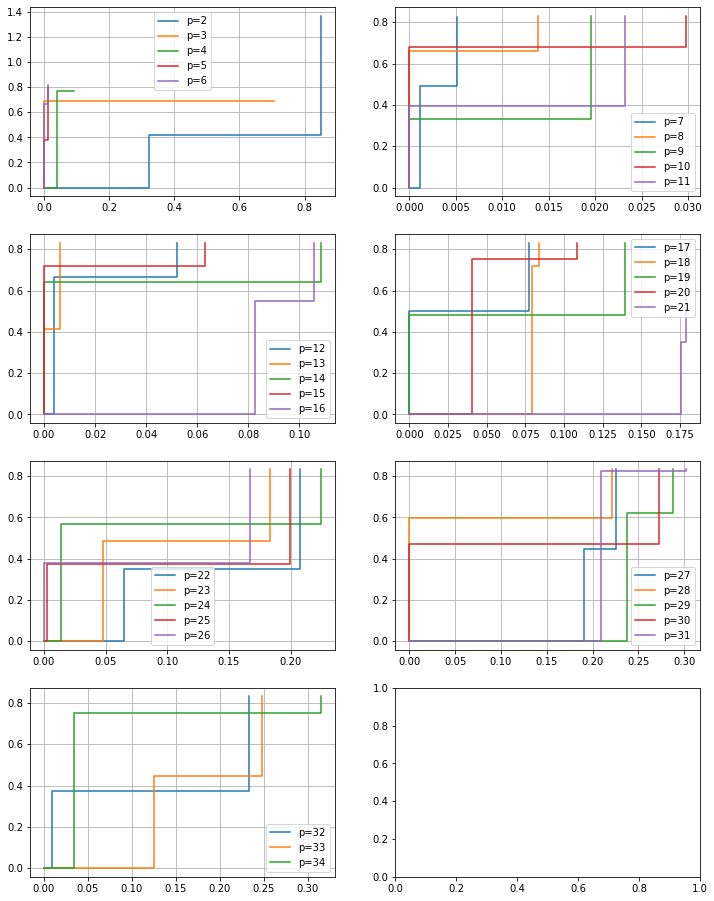

In [11]:
num_vert_plots = int(np.ceil(len(ps)/10))
fig, axs = plt.subplots(num_vert_plots, 2, figsize=(12, 4*num_vert_plots))

for idx in range(len(r)):
    P = ps[idx]
    if idx % 5 == 0:
        ax = axs[idx // 10, (idx % 10)//5]
        ax.grid()

    qs = np.array([0,*[sum(r[idx]['x'][:k][:i+1]) for i in range(k)]])
    ms = np.array([0,*[sum(r[idx]['x'][k:][:i+1]) for i in range(k)]])
    ax.step(qs, ms, where='post', label="p=" + str(P))
    if idx % 5 == 4:
        ax.legend()

ax.legend()

I notice that the locations of the symmetry breaking points are often at very low values.  This may be related to the Auffinger Chen Zeng result that perturbing a solution to this variational near $1$ will reduce the energy. So perhaps perturbations very close to $0$ can also reduce the energy: https://doi.org/10.1002/cpa.21886

## Finding the large-p limit

Let's look at the constants after dividing out by $c_p$:

In [12]:
outs = np.array([i['fun'] for i in r])
outs_scaled = np.array(outs)* C_psq**-0.5

In [13]:
0.763168*2**0.5

1.0792825359691502

In [14]:
for p, x in zip(ps, outs_scaled):
    print(p, x)

2 1.079904804039855
3 1.1504400196425635
4 1.167404239276317
5 1.1732877660135788
6 1.1756084394212536
7 1.1765950389761741
8 1.177033196098215
9 1.1772332608526037
10 1.177326289780168
11 1.1773700825412408
12 1.1773908746566917
13 1.1774008072978153
14 1.177405574042931
15 1.1774078697690966
16 1.177408978569352
17 1.1774095153629682
18 1.177409775754515
19 1.1774099022850633
20 1.1774099638625835
21 1.1774099938704379
22 1.1774100085115475
23 1.1774100156628942
24 1.1774100191594223
25 1.1774100208705542
26 1.177410021708637
27 1.177410022119441
28 1.1774100223209554
29 1.1774100224198536
30 1.1774100224684285
31 1.1774100224923065
32 1.1774100225040434
33 1.1774100225098036
34 1.1774100225126474


In [15]:
guess = (2*np.log(2))**0.5

In [16]:
print(guess)

1.1774100225154747


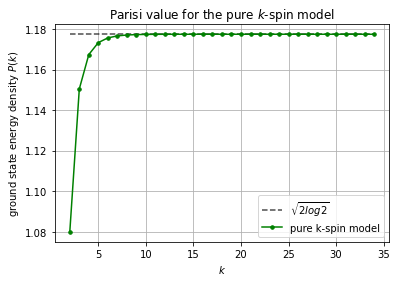

In [17]:
plt.plot(ps, [guess]*len(ps), 'b--', 
         color='black', label="$\sqrt{2 log 2}$", alpha=0.7)
plt.plot(ps, outs_scaled, 'g.-', ms=7,label="pure k-spin model")
plt.xlabel("$k$")
plt.ylabel("ground state energy density $P(k)$")
plt.title("Parisi value for the pure $k$-spin model")
plt.grid()
plt.legend()
plt.savefig('images/parisi_value.png', dpi=300)

## Relationship with $c_{p}$

I ran the above several times for different $c_p$. 
The asymptotic value seems to depend on the constant I use. If $c_p^2 < 2 log(2)$, The energy is $log(2) + c_p^2 / 2$. Otherwise, the energy is $\sqrt{ 2 c_p^2 log(2)}$.

Text(0, 0.5, '$energy / C_p$')

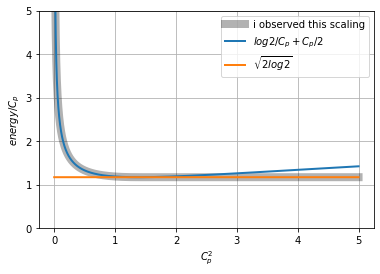

In [18]:
# this is what I observed after running for many different c_p^2
inps = np.linspace(1e-10, 5, 100000)
f1 = lambda x: x**-0.5 * (np.log(2) + x/2)
f2 = lambda x: x**-0.5 * (2 * x * np.log(2))**0.5

plt.plot(inps, [f1(i) if i < 2*np.log(2) else f2(i) for i in inps], 
         label='i observed this scaling',
         linewidth=8, alpha=0.3, color='black')
plt.plot(inps, f1(inps), label='$log 2/C_p +C_p/2$', linewidth=2)
plt.plot(inps, f2(inps), label='$\sqrt{2 log 2}$', linewidth=2)
# plt.plot(inps, inps**0.5, label='sqrt(x) (expected scaling)', linewidth=2)
plt.legend()
plt.grid()
plt.ylim(0,5)
plt.xlabel('$C_p^2$')
plt.ylabel("$energy / C_p$")

The minimum energy should be proportional to $c_p$. I think this means the limit of $P(p)$ is in fact $\sqrt{2 log 2}$.

This ended up being true, because of the relationship to the random energy model.

## Comparison with Montanari for Max 2XOR, Max 3XOR

This also roughly matches the calculation in https://arxiv.org/pdf/2009.11481.pdf that does Max 2XOR and Max 3XOR. They get
$$
e_2 = 0.763168\pm 0.000002
$$
and 
$$
e_3 = 0.8132\pm 0.0001
$$

Where $e_2$ uses $\xi(s) = s^2/2$ and $e_3$ uses $\xi(s) = s^3/2$.

In [19]:
for p, o in list(zip(ps, outs_scaled))[:2]:
    print("my result, p:", p, "e_p:", o * 2**-0.5)

my result, p: 2 e_p: 0.7636080099725112
my result, p: 3 e_p: 0.8134839392376416


/The agreement gives me confidence that my approach is correct.

Note: This matches Table 1 in the original Parisi paper! (k=0 -> 0.798, k=1 -> 0.7652, k=2 -> 0.7636)

One way to improve my precision is to explicitly solve for the derivative, and use it in the optimization procedure (as the Montanari paper does).

## Using the Parisi constants in Sen's Max XOR upper bound

I insert these values for Subhabrata Sen's bounds for Max XOR on hypergraphs, as listed here: https://doi.org/10.1002/rsa.20774

The satisfying fraction for Max CUT on p-uniform hypergraphs is to first order in D: $\frac{1}{2}+ \frac{P_p \sqrt{p}}{2}\frac{1}{\sqrt{D}}$

This makes the satisfying fraction $\frac{1}{2} + \frac{C_p}{\sqrt{D}}$, where $C_p$ is listed below:

In [20]:
for p, x in zip(ps, outs_scaled):
    print(p, x * p**0.5 / 2)

2 0.7636080099725112
3 0.9963102825407285
4 1.167404239276317
5 1.311775600987615
6 1.4398204069458498
7 1.556488933481653
8 1.6645763092854464
9 1.7658498912789056
10 1.8615163124503746
11 1.9524474015895312
12 2.0393008152733496
13 2.122589491242484
14 2.2027241316732726
15 2.2800405356546314
16 2.354817957138704
17 2.427291898224409
18 2.4976633100140493
19 2.5661053895923454
20 2.6327687165823077
21 2.6977852104543865
22 2.7612712298482007
23 2.823330034490115
24 2.88405376498115
25 2.9435250521763856
26 3.001818338096022
27 3.059000969477501
28 3.115134110216257
29 3.1702735081514213
30 3.224470143693114
31 3.277770781835779
32 3.3302184445984584
33 3.381852817484659
34 3.4327106008899846


Because of the limit, we expect a large $p$XORSAT problem to have satisfying fraction at most

$$\frac{1}{2} + \frac{\sqrt{2 log 2}}{2} \sqrt{\frac{p}{D}} = \frac{1}{2} + \sqrt{\frac{p log 2}{2}} \frac{1}{\sqrt{D}} \approx \frac{1}{2} + 0.58871\sqrt{\frac{p}{D}}$$

## Bonus: Evaluating the $p$-SAT approximations

A similar formula to Sen has been done by Panchenko for $p$-SAT: https://arxiv.org/pdf/1608.06256.pdf

Given $N$ variables and $\alpha N$ clauses, the satisfying fraction is 
$$1-\frac{1}{2^p} + \frac{B_p}{2^p}\frac{1}{\sqrt{\alpha}}$$

Where $B_p$ is the limit of a Parisi formula with $\xi(x) = (1+x)^p - 1$.

In [21]:
# set parameters
# k is number of jumps
k=2
# if this range is too small, it fails at higher p
INPS = np.linspace(-30, 30, 400)
PDF_INPS = stats.norm.pdf(INPS)
PDF_INPS = PDF_INPS/np.sum(PDF_INPS)
assert np.allclose(sum(PDF_INPS),1), sum(PDF_INPS)
grid = np.meshgrid(*[INPS]*(k+1), indexing='ij')

In [22]:
ksat_ps = range(3, 10)

# CONST_SQ may affect my convergence.
CONST_SQ = 0.5

def run_ksat(P):
#     xi = lambda x: CONST_SQ* (-1 + (1+x)**P)
    xiprime = lambda x: CONST_SQ* P * ((1+x)**(P-1))
    xiprimeprime = lambda x:CONST_SQ* P * (P-1) * ((1+x)**(P-2))
    opt = minimize(make_test(xiprime, xiprimeprime, k, PDF_INPS), 
                       [np.random.random()/k for _ in range(2*k)], 
                       method='Powell', 
                       options={"xtol": 1e-10, "ftol":1e-14}
                      )
    print("p:", P, opt.fun)
    return {"x": opt.x, "fun": opt.fun}

In [23]:
%%time

print("kSAT:")
r_ksat = []
for P in ksat_ps:
    r_ksat.append(run_ksat(P))
# pool = multiprocessing.Pool(processes=n_proc)
# r_ksat = pool.map(run_ksat, ksat_ps)
# pool.close()

kSAT:
p: 3 1.5681444028917366
p: 4 2.6570658272125645
p: 5 4.135420402431401


/tmp/ipykernel_70773/3977490124.py:9: RuntimeWarning: overflow encountered in exp
  start = np.log(np.sum(np.exp(ms[i]*start)*PDF_INPS, axis=i))/ms[i]
/home/kunal/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


p: 6 6.174495466368439
p: 7 9.3617669879651
p: 8 12.984169021100051
p: 9 18.558779309269934
CPU times: user 3h 23min 36s, sys: 1h 10min 19s, total: 4h 33min 56s
Wall time: 4h 33min 59s


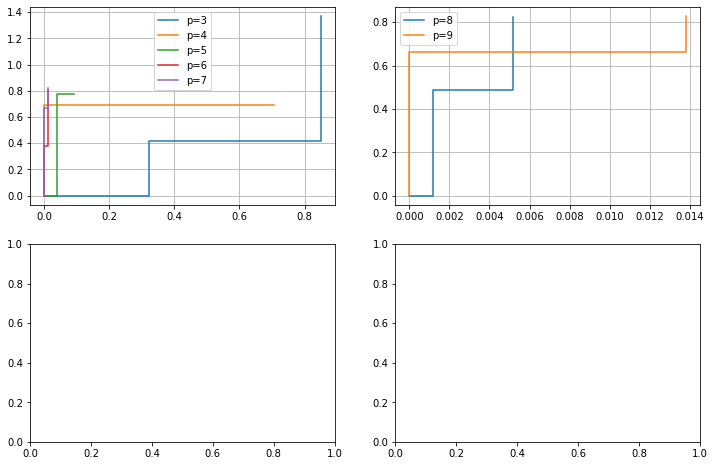

In [31]:
num_vert_plots = int(np.ceil(len(ksat_ps)/5))
fig, axs = plt.subplots(num_vert_plots, 2, figsize=(12, 4*num_vert_plots))

for idx in range(len(r_ksat)):
    P = ksat_ps[idx]
    if idx % 5 == 0:
        ax = axs[idx // 10, (idx % 10)//5]
        ax.grid()

    qs = np.array([0,*[sum(r[idx]['x'][:k][:i+1]) for i in range(k)]])
    ms = np.array([0,*[sum(r[idx]['x'][k:][:i+1]) for i in range(k)]])
    ax.step(qs, ms, where='post', label="p=" + str(P))
    if idx % 5 == 4:
        ax.legend()

ax.legend()

The constants after reducing by CONST_SQ (to help with convergence):

In [32]:
outs = np.array([i['fun'] for i in r_ksat])
ksats_scaled = outs * CONST_SQ**-0.5

In [33]:
for p,o in zip(ksat_ps, ksats_scaled):
    print(p, o)

3 2.217691082328953
4 3.7576585289620956
5 5.84836761923289
6 8.732055229349436
7 13.239537842156965
8 18.362387925784287
9 26.246077400258724


I calculate $C$, where the satisfying fraction is $1-1/2^p + C/\sqrt{\alpha}$:

In [34]:
for p,o in zip(ksat_ps, ksats_scaled):
    print(p, o*2**(-p))

3 0.2772113852911191
4 0.23485365806013098
5 0.18276148810102782
6 0.13643836295858494
7 0.10343388939185129
8 0.07172807783509487
9 0.05126186992238032


It would be nice to get a confirmation on this constant, but I haven't seen it calculated anywhere.

In [35]:
print("Ending time:", time.ctime())

Ending time: Sat Sep 11 18:09:43 2021
